In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# Validation of OSACA
OSACA predicts the minimal (throughput and loop-carried dependency latency) and maximum (critical path latency) instruction execution time for assembly loop bodies, under the assumption that all loads and stores are served by the first level cache.

In this validation study OSACA is compared to measured runtimes of assembly blocks in a large dataset. The prediction accuracy is also compared to three other tools with the same goal im mind: IACA, LLVM-MCA and Ithemal.

## Validation Dataset
The validation dataset is created by compiling several kernels with diffent compilers and optimization flags. Kernels represent the domain of numerical codes and all use double precision floating-point arithmetics. The original high-level C implementations are found in the `validation/kernels` directory and include:
 * Simple load-store heavy kernels: `add`, `copy`, `store`, `striad`, `triad` and `update`
 * Stencils: `2d-5pt`, `3d-7pt`, `3d-27pt` and `3d-r3-11pt`
 * Dependency chain: `gs-2d-5pt` and `sumreduction`
 * Slow arithmetic: `pi` (divide)

All these kernels are compiled with `gcc`, `clang` and `icc` (where applicable) and for each compiler with `-O1`, `-O2`, `-O3` and `-Ofast`, which results in 6-9 variantes per kernel. Additional kernels, compiler and flags can be configured in the `build_and_run.py` script.

## Runtimes and Ground Truth Measurements

Reported cycle runtimes in this notebook –unless otherwise noted– are scaled to high-level code iterations to make them comparable. Raw outputs by the tools will refer to assembly block iterations. Since all provided kernels are double precision based, the `pointer_increment` divided by `8` gives the used scaling factor.

Measured runtimes are gained by traversing 8 to 1024 elements (for a total of 25 million iterations) and selecting the smallest measured runtime out of all executions.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.rc = {"figure.dpi": 100}
from pathlib import Path
import pickle
from pprint import pprint, pformat
from itertools import product
import warnings
from functools import reduce

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import pandas as pd
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from IPython.display import display, HTML

def boxprint(*args):
    for arg in args:
        display(HTML('<pre style="white-space: pre !important;">{}</pre>'.format(arg)))

pd.set_option('display.max_rows', 1000)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:264: DeprecationWarning: 'U' mode is deprecated


In [3]:
# Load data from build/ directory. The data can either be generated using build_and_run.py or downloaded from a 
# OSACA release from github. Look for releases including validation data archives.
data = []
for p in Path('build/').glob('*/data.pkl'):
    data += pickle.loads(p.read_bytes())
df = pd.DataFrame(data)
archs = ['IVB', 'SKX', 'ZEN', 'ZEN2', 'TX2', 'A64FX']
archs += [a for a in sorted(df.arch.unique()) if a not in archs]
models = ['IACA', 'Ithemal', 'LLVM-MCA', 'OSACA']
kernels = sorted(df.kernel.unique())
compilers = sorted(df.compiler.unique())
cflags_names = sorted(df.cflags_name.unique())

# Add more data
df['worst_runtime'] = df.allruns.map(lambda ar: max([r[2] for r in ar]), na_action='ignore')
for pred in models:
    df[pred+'_err'] = df['best_runtime'] - df[pred+'_prediction']
    df[pred+'_relerr'] = df[pred+'_err']/df['best_runtime']
    df[pred+'_tperr'] = df['best_runtime'] - df[pred+'_throughput']
    df[pred+'_reltperr'] = df[pred+'_tperr']/df['best_runtime']
df['instruction count'] = df.OSACA_raw.map(lambda r: len([l for l in r['analyzed kernel'] if l.get('instruction')]))

# Clean up
# TODO do this in pickle files!
del df['IACA_scaled_max'], df['OSACA_scaled_max'], df['LLVM-MCA_scaled_max']
del df['IACA_scaled'], df['OSACA_scaled'], df['LLVM-MCA_scaled']

# Make indexed representation
df_idx = df.set_index(['arch', 'compiler', 'cflags_name', 'kernel'], verify_integrity=True)
df_idx.sort_index(inplace=True)

In [4]:
# Check for missing instructions in all OSACA analyses
for idx, raw in df.OSACA_raw.items():
    if not isinstance(raw, dict): continue
    count = 0
    for l in raw['analyzed kernel']:
        if 'tp_unknown' in l['flags']:
            print(df['arch'][idx]+'/'+df['compiler'][idx]+'/'+df['cflags_name'][idx]+'/'+df['kernel'][idx]+'.marked.s', l['line'])
            count += 1
if not count:
    print("\u2705 All instructions in test dataset are defined in OSACA microarchitecture databaseses.")
else:
    print(count,
          "instructions were not found in OSACA microarchitecture databaseses. "
          "This may lead to unnecessary underpredictions.")

✅ All instructions in test dataset are defined in OSACA microarchitecture databaseses.


## Statistics on Dataset and Measurements
The following histogram/bar plots give an overview on of the wide range of kernels found in the dataset.

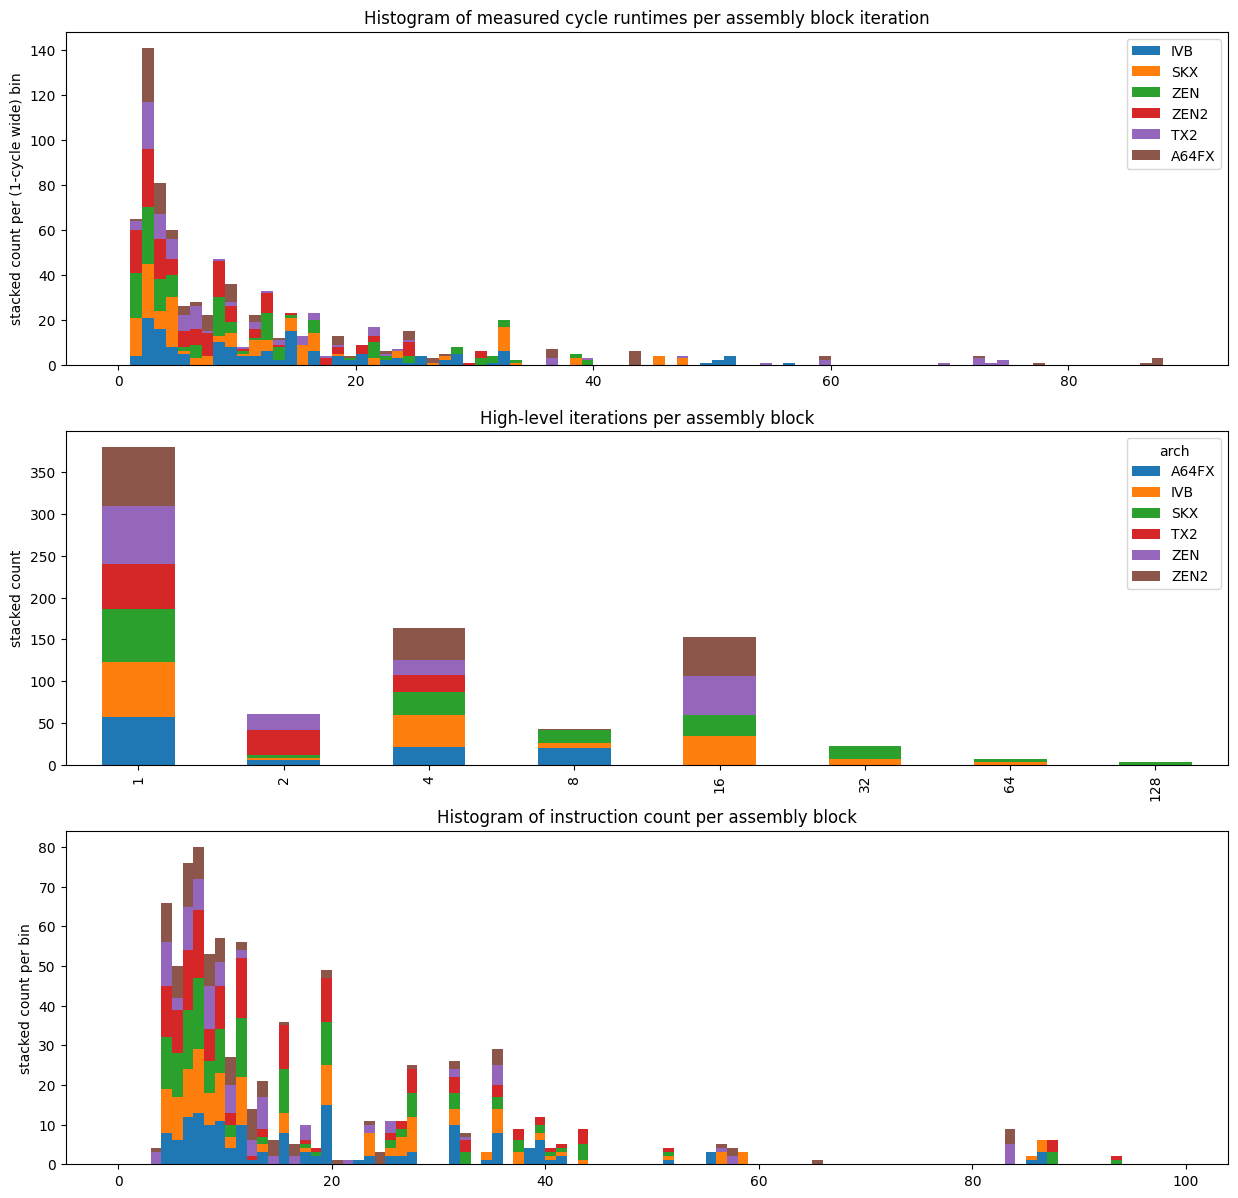

In [5]:
fig, axs = plt.subplots(3, figsize=(15, 15))
df['best_runtime_asm'] = (df.best_runtime * (df.pointer_increment // 8))
axs[0].hist(
    [df.best_runtime_asm[df.arch == a] for a in archs],
    bins=range(0,90),
    label=archs,
    stacked=True,
)
axs[0].legend()
axs[0].set_ylabel('stacked count per (1-cycle wide) bin')
axs[0].set_title('Histogram of measured cycle runtimes per assembly block iteration')

(df.pointer_increment // 8).groupby(df.arch).value_counts().sort_index().unstack('arch').plot(
    kind='bar',
    ax=axs[1],
    stacked=True,
    legend=True
)
axs[1].set_xlabel('')
axs[1].set_ylabel('stacked count')
axs[1].set_title("High-level iterations per assembly block")

axs[2].hist(
    [df['instruction count'][df.arch == a] for a in archs],
    bins=range(0,100),
    label=archs,
    stacked=True,
)
axs[0].legend()
axs[2].set_ylabel('stacked count per bin')
axs[2].set_title("Histogram of instruction count per assembly block");

In [6]:
instruction_forms = reduce(
    set.union,
    df.OSACA_raw.map(lambda r: {l['instruction']+repr([','.join(o.keys()) for o in l['operands']])
                                for l in r['analyzed kernel']
                                if l['instruction']}))
print("A total of",
      len(instruction_forms),
      "different instruction forms (different in name or operand type) found in dataset.")

A total of 114 different instruction forms (different in name or operand type) found in dataset.


The following plot show the convergence of the kernel runtimes towards a minimum plataeu, which is used as ground truth and to be predicted. Noise, toxic loop lengths and runtime increases towards the right are to be expected. Double click on plot to enlarge.

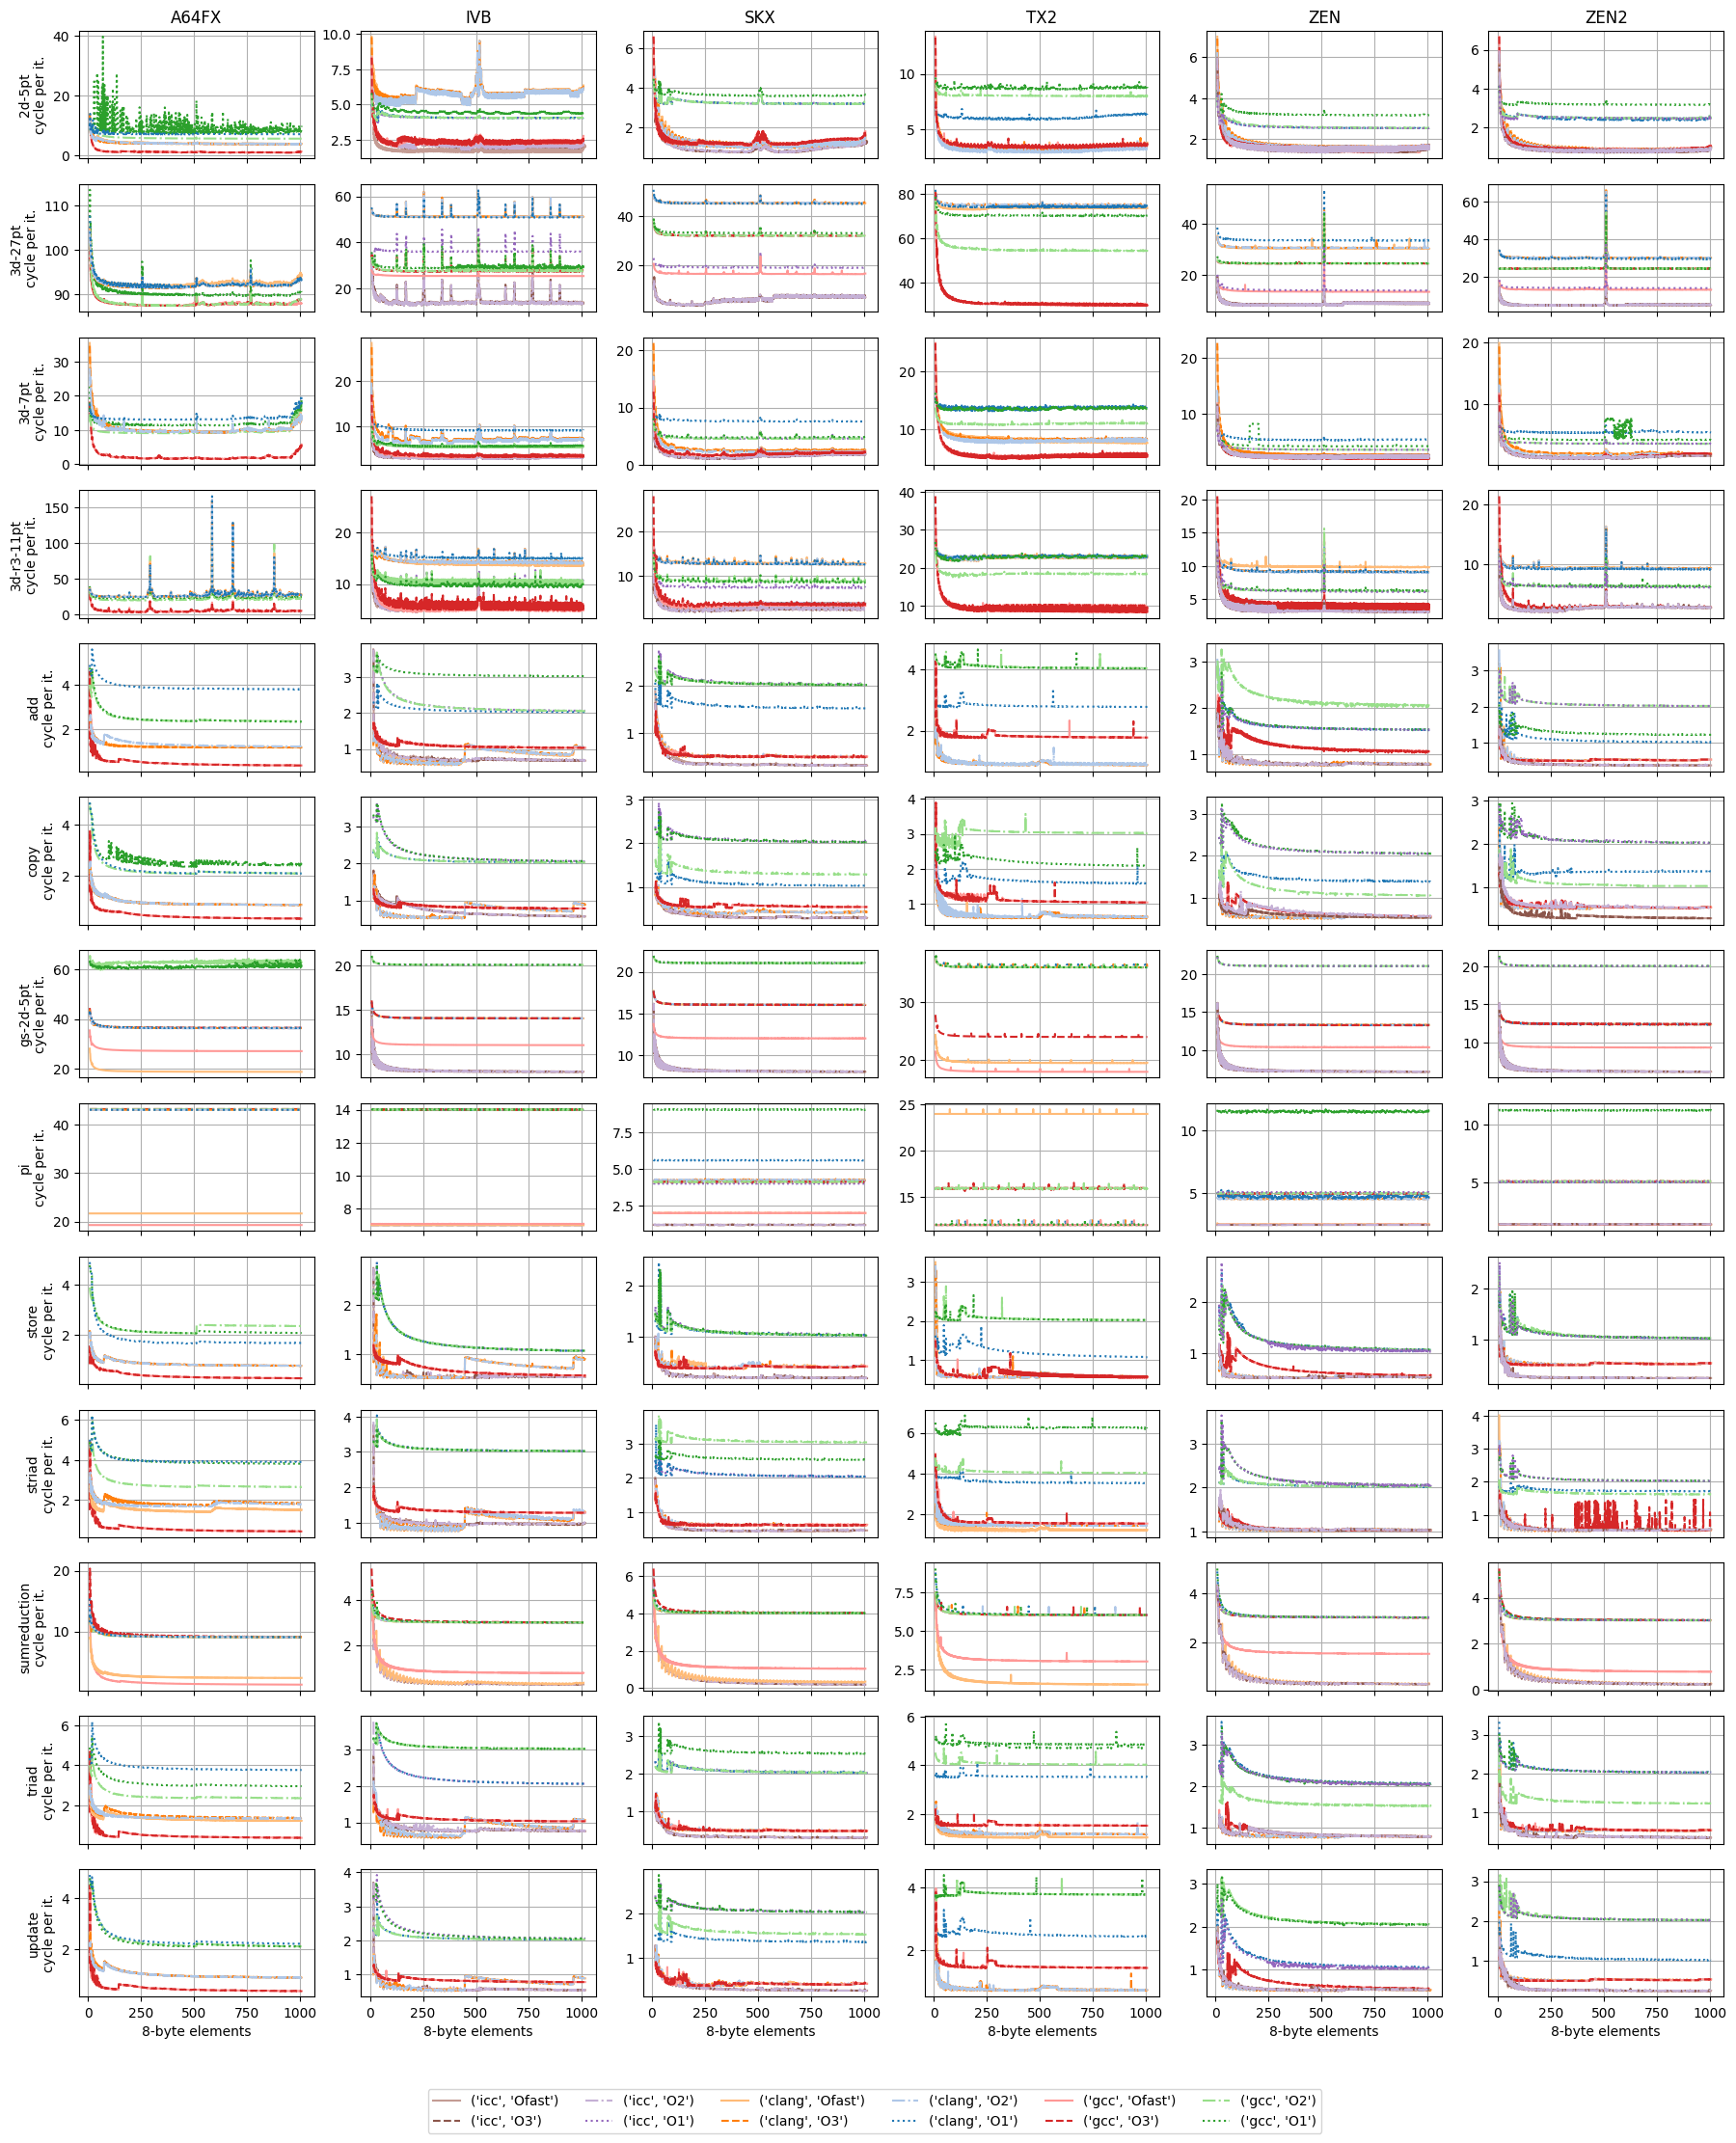

In [7]:
kernels = sorted(df.kernel.unique())
archs = sorted(df.arch.unique())
compiler_flags_prod = list(product(sorted(df.compiler.unique()), sorted(df.cflags_name.unique())))
linestyle_dict = {'Ofast': '-', 'O3': '--', 'O2': '-.', 'O1': ':'}

kernels = sorted(df.kernel.unique())
fig, axs = plt.subplots(len(kernels), len(archs), figsize=(3.5*len(archs)+1,2*len(kernels)+1),
                        sharex=True, dpi=100, squeeze=False)
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
handles = []
for ki, kernel in enumerate(kernels):
    for ai, arch in enumerate(archs):
        for idx, row in df.query('kernel == @kernel and arch == @arch').iterrows():
            if type(row.allruns) is list:
                color_index = compiler_flags_prod.index((row.compiler, row.cflags_name))
                handles = axs[ki,ai].plot(
                    [r[0] for r in row.allruns][:1000], [r[2] for r in row.allruns][:1000],
                    color=colors[color_index],
                    linestyle=linestyle_dict[row.cflags_name],
                    label=str((row.compiler, row.cflags_name)))
            
            if ki == 0:
                axs[ki,ai].set_title(arch)
            elif ki == len(kernels) - 1:
                axs[ki,ai].set_xlabel("8-byte elements")
            if ai == 0:
                axs[ki,ai].set_ylabel(kernel+"\ncycle per it.")
            axs[ki,ai].grid(True)
fig.legend(handles=axs[0,1].lines, loc="lower center", bbox_to_anchor=(0.5, 0.07), ncol=6);

## Evaluation and Statistics on Predictions
Predictions are evaluated with a relative error metric: $\mathrm{rel. error} = (T_\mathrm{measured} - T_\mathrm{predicted})/T_\mathrm{measured}$. Optimally this is to be zero. If the relative error is negative the model has *underpredicted* and failed being a lower bound model, because it predicted a faster runtime than was measured. If the realtive error is positive, the model *overpredicted*, then it is inaccurate and predicted a faster runtime than was measured. A relative prediction error larger than one would indicate a negative absolue runtime prediction and is therefore not possible.

The following table and plot give an overview of the models relative errors in regard to the used dataset. The number of tests depend on the architecture (`icc` does not compile for `aarch64`) and model (IACA and Ithemal do not support non-Intel architectures and Ithemal fails on AVX512 instructions) used.

In [8]:
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}".format("model", "tests", "+20% fit", "avg(relerr < 0)", "avg(relerr > 0)", "min(relerr)"))
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}".format("", "", "+10% fit", "sum(relerr < 0)", "sum(relerr > 0)", "max(relerr)"))
print(" "*25+"  not lower bound         accuracy\n")
for m in models:
    line = "{:>8}  ".format(m)
    line2 = " "*10
    mr = df[df[m+'_relerr'].notna()]
    # Test count
    line += "{:>5}  ".format(len(mr))
    line2 += " "*7
    # Fit
    line += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.2")))
    line2 += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.1")))
    # Sum relative error < 0 (bad)
    relerr_neg = mr[mr[m+'_relerr'] < 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_neg)/len(relerr_neg))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_neg))
    # Sum relative error > 0 (could be better)
    relerr_pos = mr[mr[m+'_relerr'] > 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_pos)/len(relerr_pos))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_pos))
    if not mr[m+'_relerr'].empty:
        line += "{:>15.3f}  ".format(min(mr[m+'_relerr']))
        line2 += "{:>15.3f}  ".format(max(mr[m+'_relerr']))
    print(line)
    print(line2)

   model  tests  +20% fit  avg(relerr < 0)  avg(relerr > 0)      min(relerr)
                 +10% fit  sum(relerr < 0)  sum(relerr > 0)      max(relerr)
                           not lower bound         accuracy

    IACA    312       194           -0.079            0.181           -0.209  
                      137           -0.943           54.326            0.892  
 Ithemal    269        23           -7.728            0.313          -57.589  
                       16        -1506.900           23.143            0.873  
LLVM-MCA    832       138           -0.410            0.354           -2.312  
                       70         -133.524          179.195            0.954  
   OSACA    832       366           -0.007            0.257           -0.080  
                      254           -0.105          209.860            0.954  


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:264: DeprecationWarning: 'U' mode is deprecated
/Users/codemonk/python37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/codemonk/python37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


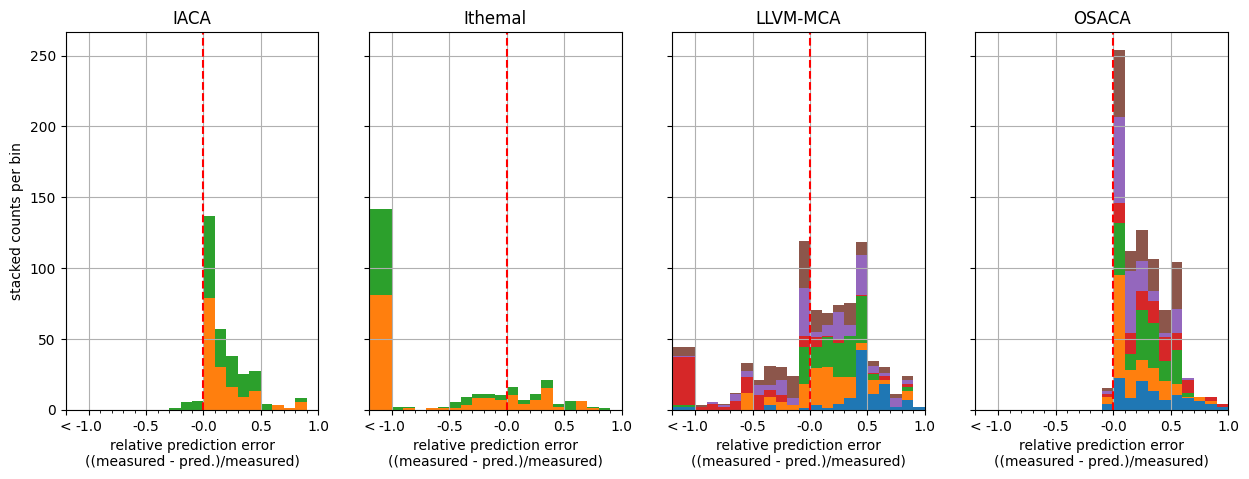

In [9]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey='all', sharex='all')
for i, m in enumerate(models):
    h = axs[i].hist(
        [df[df.arch == a][m+'_relerr'] for a in archs],
        bins=[-100.0]+inner_bin_edges,
        stacked=True,
        label=archs,
    )
    axs[i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
    axs[i].set_xticks(inner_bin_edges, minor=True)
    axs[i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
    axs[i].axvline(0, color='red', linestyle='--')
    if i == 0:
        axs[i].set_ylabel('stacked counts per bin')
    axs[i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
    axs[i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
    axs[i].set_title(m)
    axs[i].grid(True)
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

* IACA shows the best average overprediction with about 18%. It does underpredict, but rearly. Almost two-thirds of the applicable tests are predicted within 20% of the measured runtime.
* Ithemal underpredicts most of the time and gives a reasonable prediction in in less than one-tenth of the sucessfully run test cases.
* LLVM-MCA underpredicts quite often, none the less, most overpredictions are within 0 and +50% of the measured runtime, 35% on average.
* OSACA seldomly under predicts (details on this follow below), and 44% of all test cases show a relative error of 20% or less.

In [10]:
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}".format("µarch", "tests", "+20% fit", "avg(relerr < 0)", "avg(relerr > 0)", "min(relerr)"))
print("{:>8}  {:>5}  {:>8}  {:>15}  {:>15}  {:>15}\n".format("", "", "+10% fit", "sum(relerr < 0)", "sum(relerr > 0)", "max(relerr)"))
for a in archs:
    m = 'OSACA'
    line = "{:>8}  ".format(a)
    line2 = " "*10
    mr = df[df[m+'_relerr'].notna()][df.arch == a]
    # Test count
    line += "{:>5}  ".format(len(mr))
    line2 += " "*7
    # Fit
    line += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.2")))
    line2 += "{:>8}  ".format(len(mr.query("0 < `"+m+"_relerr` < 0.1")))
    # Sum relative error < 0 (bad)
    relerr_neg = mr[mr[m+'_relerr'] < 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_neg)/len(relerr_neg))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_neg))
    # Sum relative error > 0 (could be better)
    relerr_pos = mr[mr[m+'_relerr'] > 0][m+'_relerr']
    if len(relerr_neg):
        line += "{:>15.3f}  ".format(sum(relerr_pos)/len(relerr_pos))
    else:
        line += " "*14+"-  "
    line2 += "{:>15.3f}  ".format(sum(relerr_pos))
    if not mr[m+'_relerr'].empty:
        line += "{:>15.3f}  ".format(min(mr[m+'_relerr']))
        line2 += "{:>15.3f}  ".format(max(mr[m+'_relerr']))
    print(line)
    print(line2)

   µarch  tests  +20% fit  avg(relerr < 0)  avg(relerr > 0)      min(relerr)
                 +10% fit  sum(relerr < 0)  sum(relerr > 0)      max(relerr)

   A64FX    104        30           -0.025            0.343           -0.080  
                       22           -0.102           34.319            0.941  
     IVB    156        93           -0.000            0.194           -0.000  
                       73           -0.001           29.280            0.806  
     SKX    156        48                -                -            0.001  
                       37            0.000           42.135            0.621  
     TX2    104        29           -0.000            0.349           -0.000  
                       14           -0.000           35.612            0.954  
     ZEN    156       105           -0.000            0.178           -0.000  
                       61           -0.001           27.372            0.647  
    ZEN2    156        61           -0.001            0

This breakdown of OSACA predictions by archiecture reveals that IVB and ZEN are best predicted and TX2 and A64FX worst.

## Intel Ivy Bridge (IVB) and Skylake X (SKX)

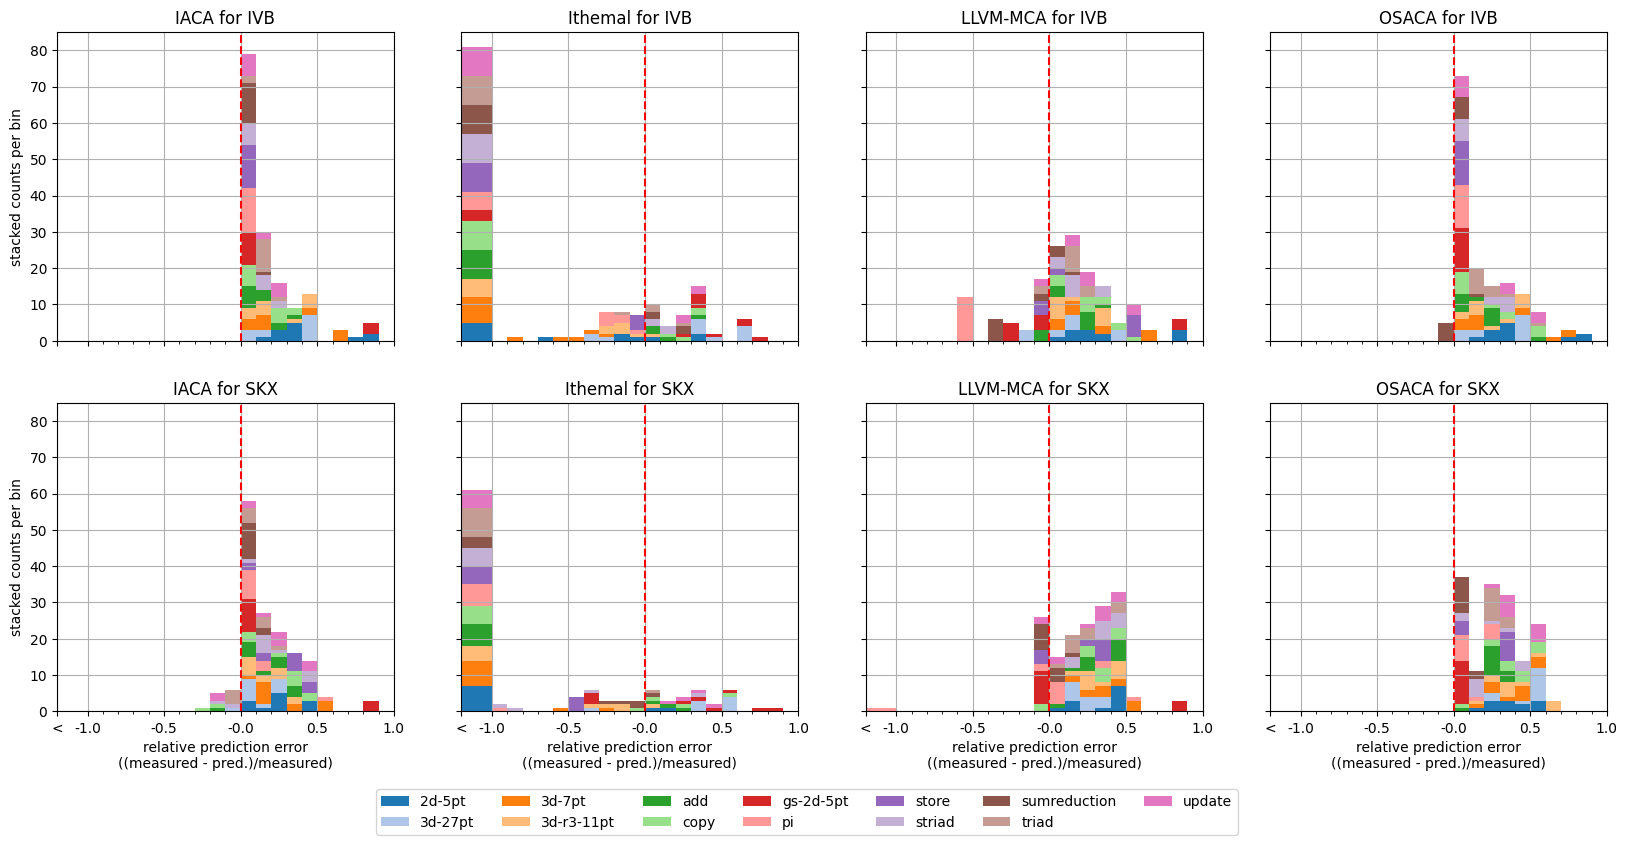

In [11]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
fig, axs = plt.subplots(2, len(models), figsize=(20, 9), sharey='all', sharex='all')
for j, a in enumerate(['IVB', 'SKX']):
    for i, m in enumerate(models):
        h = axs[j,i].hist(
            [df[df.arch == a][m+'_relerr'][df.kernel == k] for k in kernels],
            bins=[-100.0]+inner_bin_edges,
            stacked=True,
            label=kernels,
            color=colors[:len(kernels)]
        )
        axs[j,i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
        axs[j,i].set_xticks(inner_bin_edges, minor=True)
        axs[j,i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
        axs[j,i].axvline(0, color='red', linestyle='--')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts per bin')
            axs[j,i].set_yticks(range(0, 81, 10))
        if j == axs.shape[0]-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
            axs[j,i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], kernels, ncol=7, loc="lower center", bbox_to_anchor=(.5, -0.02));
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

Predictions on Skylake are challenging to both LLVM-MCA and OSACA, while IACA gives good results. Looking at individual IACA prediction reports quickly reveals that IACA assumes many of the more-than-20%-off OSACA predictions to be bound by a frontend bottleneck. Since frontend bottlenecks are not modled by OSACA, this is to be expected. While this does not explain the whole discrepancy, some can be accounted to this, as shown in the following plot.

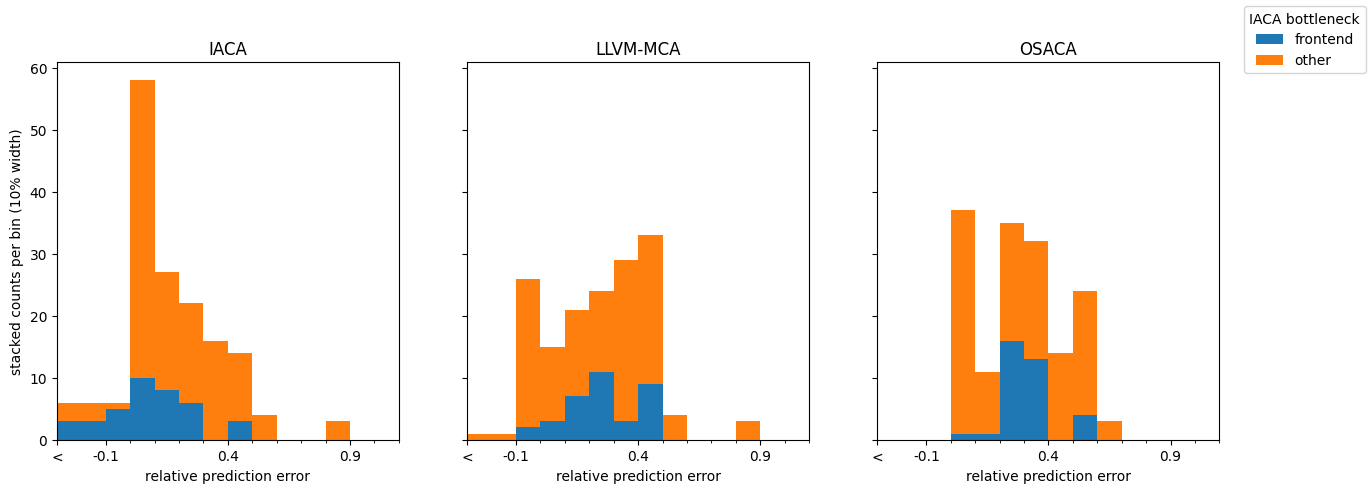

In [12]:
inner_bin_edges = list(np.arange(-0.1, 1.1, 0.1))
df['IACA_frontend'] = df.IACA_raw.map(lambda r: "FrontEnd" in r['output'], na_action='ignore')
df.IACA_frontend.fillna(False, inplace=True)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].hist(
    [df[df.arch == "SKX"]['IACA_relerr'][df.IACA_frontend == b] for b in [True, False]],
    bins=[-100.0]+inner_bin_edges,
    stacked=True,
)
axs[0].set_ylabel("stacked counts per bin (10% width)")
axs[0].set_title("IACA")

axs[1].hist(
    [df[df.arch == "SKX"]['LLVM-MCA_relerr'][df.IACA_frontend == b] for b in [True, False]],
    bins=[-100.0]+inner_bin_edges,
    stacked=True,
)
axs[1].set_title("LLVM-MCA")


h = axs[2].hist(
    [df[df.arch == "SKX"]['OSACA_relerr'][df.IACA_frontend == b] for b in [True, False]],
    bins=[-100.0]+inner_bin_edges,
    stacked=True,
)
axs[2].set_title("OSACA")

for i in range(3):
    axs[i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
    axs[i].set_xticks(inner_bin_edges, minor=True)
    axs[i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
    axs[i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
    axs[i].set_xlabel("relative prediction error")
fig.legend(h[2], ["frontend", "other"], title="IACA bottleneck");

## AMD Zen and Zen2

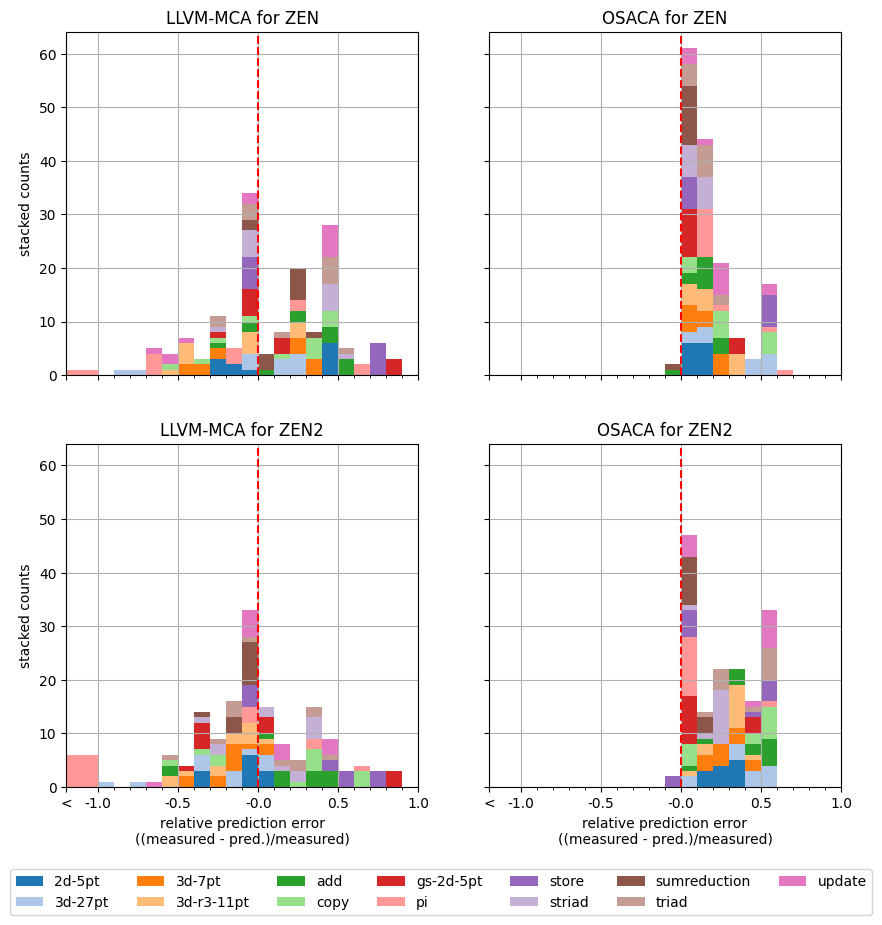

In [13]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey='all', sharex='all')
for j, a in enumerate(['ZEN', 'ZEN2']):
    for i, m in enumerate(['LLVM-MCA','OSACA']):
        h = axs[j,i].hist(
            [df[df.arch == a][m+'_relerr'][df.kernel == k] for k in kernels],
            bins=[-100.0]+inner_bin_edges+[100.0],
            stacked=True,
            label=kernels,
            color=colors[:len(kernels)],
        )
        axs[j,i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
        axs[j,i].set_xticks(inner_bin_edges, minor=True)
        axs[j,i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
        axs[j,i].axvline(0, color='red', linestyle='--')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts')
        if j == axs.shape[0]-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
            axs[j,i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], kernels, ncol=7, loc="lower center", bbox_to_anchor=(.5, -0.01));
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

## ARM-based Fujitsu A64FX and Cavium ThunderX2 (TX2)

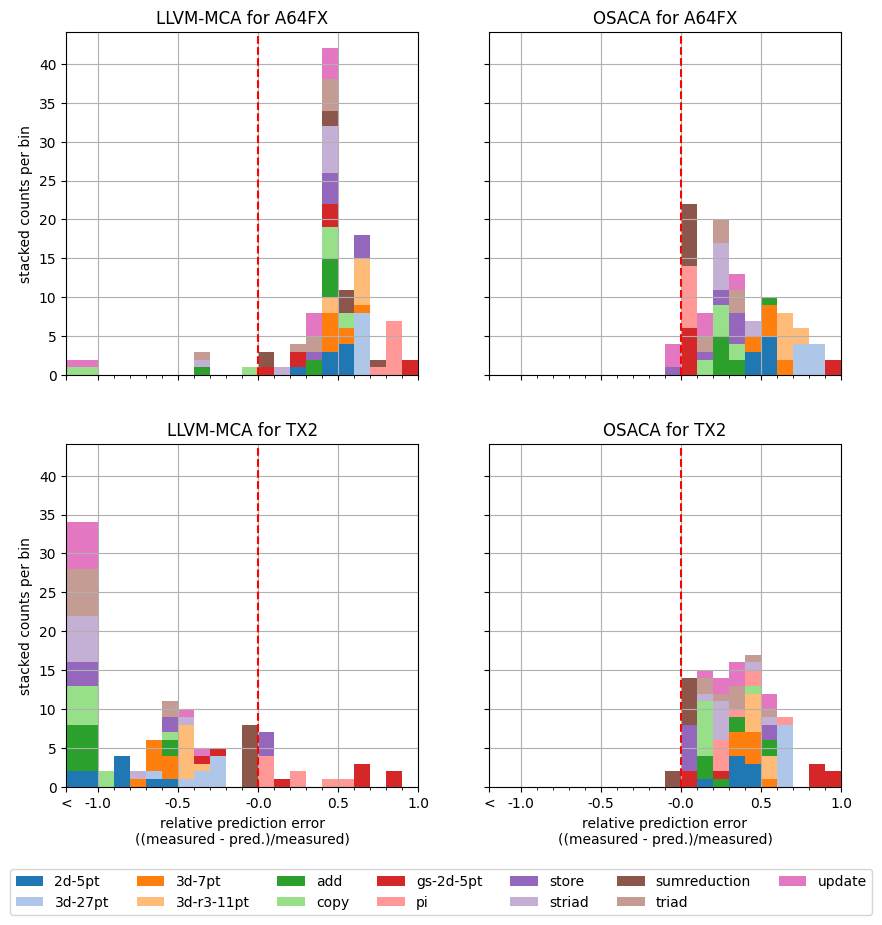

In [14]:
inner_bin_edges = list(np.arange(-1.0, 1.1, 0.1))
colors = list(map(list, plt.cm.get_cmap('tab20').colors))
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey='all', sharex='all')
for j, a in enumerate(['A64FX', 'TX2']):
    for i, m in enumerate(['LLVM-MCA','OSACA']):
        h = axs[j,i].hist(
            [df[df.arch == a][m+'_relerr'][df.kernel == k] for k in kernels],
            bins=[-100.0]+inner_bin_edges+[100.0],
            stacked=True,
            label=kernels,
            color=colors[:len(kernels)],
        )
        axs[j,i].set_xticks([min(inner_bin_edges)-0.2] + inner_bin_edges[::5])
        axs[j,i].set_xticks(inner_bin_edges, minor=True)
        axs[j,i].set_xlim(min(inner_bin_edges)-0.2, max(inner_bin_edges))
        axs[j,i].axvline(0, color='red', linestyle='--')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts per bin')
        if j == axs.shape[0]-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
            axs[j,i].set_xticklabels(['<'] + [f"{e:.1f}" for e in inner_bin_edges[::5]])
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], kernels, ncol=7, loc="lower center", bbox_to_anchor=(.5, -0.01));
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

/Users/codemonk/python37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/codemonk/python37/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


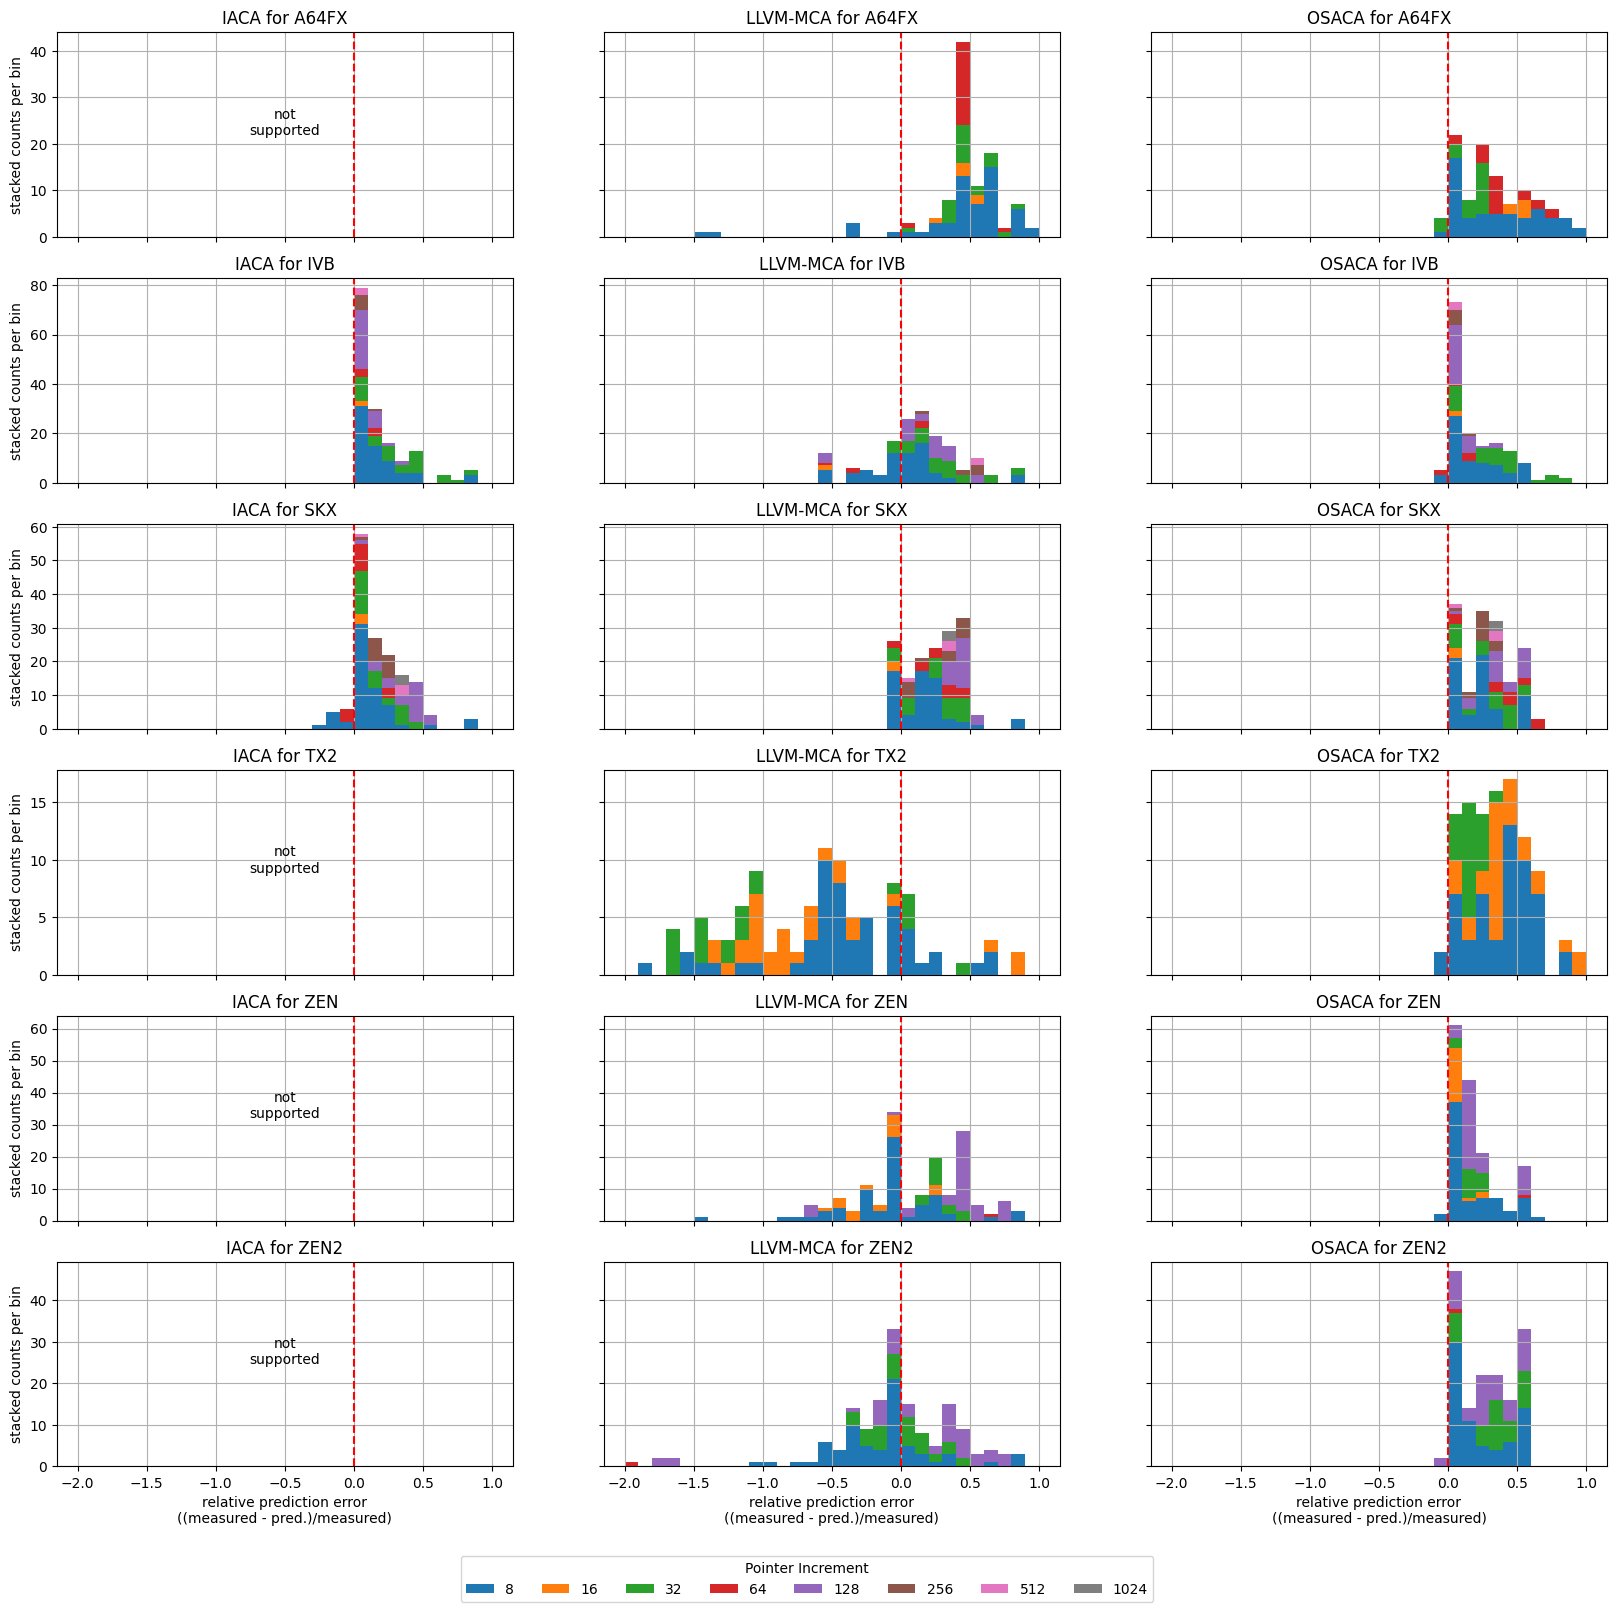

In [15]:
pi_bins = [8, 16, 32, 64, 128, 256, 512, 1024]
colors = list(map(list, plt.cm.get_cmap('tab10').colors))
fig, axs = plt.subplots(len(archs), len([m for m in models if m != "Ithemal"]),
                        figsize=(20,1+len(archs)*3), sharey='row', sharex='all')
for j, a in enumerate(archs):
    for i, m in enumerate([m for m in models if m != "Ithemal"]):
        h = axs[j,i].hist(
            [df[df.arch == a].query('pointer_increment == @pi')[m+'_relerr'] for pi in pi_bins],
            bins=np.arange(-2.0, 1.1, 0.1),
            stacked=True,
            label=map(str, pi_bins),
            color=colors[:len(pi_bins)],
        )
        axs[j,i].axvline(0, color='red', linestyle='--')
        if df[df.arch == a][m+'_relerr'].isnull().all():
            axs[j,i].text(0.5, 0.5, "not\nsupported",
                          transform=axs[j,i].transAxes, horizontalalignment='center')
        if i == 0:
            axs[j,i].set_ylabel('stacked counts per bin')
        if j == len(archs)-1:
            axs[j,i].set_xlabel('relative prediction error\n((measured - pred.)/measured)')
        axs[j,i].set_title(m+" for "+a)
        axs[j,i].grid(True)
fig.legend(h[2], pi_bins, ncol=10, loc="lower center", bbox_to_anchor=(.5, 0.05), title="Pointer Increment");
# < 0 -> underprediction (predicted too slow), lower bound model failed
# > 0 -> overprediction (predicted too fast), higher means less accurate

## Underpredictions by OSACA
The following table shows all underpredicitons, which contradict the light-speed/lower-bound model paradim:

In [16]:
# Runtime less than TP or LCD, this violates the model assumption:
df_idx.query("best_runtime < OSACA_throughput or best_runtime < OSACA_lcd").sort_values('OSACA_relerr')[
    ['best_runtime', 'OSACA_prediction', 'OSACA_relerr']]

best_runtime  OSACA_prediction  \
arch  compiler cflags_name kernel                                         
A64FX clang    O1          store             1.620002             1.750   
               O2          update            0.864065             0.875   
               O3          update            0.871200             0.875   
               Ofast       update            0.871200             0.875   
ZEN2  icc      O3          store             0.249616             0.250   
ZEN   icc      O1          add               1.499457             1.500   
ZEN2  icc      Ofast       store             0.249942             0.250   
ZEN   clang    O1          sumreduction      2.999438             3.000   
TX2   clang    O2          sumreduction      5.999024             6.000   
               O3          sumreduction      5.999029             6.000   
IVB   clang    O1          sumreduction      2.999634             3.000   
      gcc      O2          sumreduction      2.999639             3.000   
      icc      O1          sumreduction      2.999676             3.000   
      clang    O3          sumreduction      2.999714             3.000   
               O2          sumreduction      2.999747             3.000   

                                         OSACA_relerr  
arch  compiler cflags_name kernel                      
A64FX clang    O1          store            -0.080246  
               O2          update           -0.012655  
               O3          update           -0.004362  
               Ofast       update           -0.004362  
ZEN2  icc      O3          store            -0.001537  
ZEN   icc      O1          add              -0.000362  
ZEN2  icc      Ofast       store            -0.000232  
ZEN   clang    O1          sumreduction     -0.000187  
TX2   clang    O2          sumreduction     -0.000163  
               O3          sumreduction     -0.000162  
IVB   clang    O1          sumreduction     -0.000122  
      gcc      O2          sumreduction     -0.000120  
      icc      O1          sumreduction     -0.000108  
      clang    O3          sumreduction     -0.000095  
               O2          sumreduction     -0.000084

The first two underpredicted kernels on A64FX are the only ones which show an error "greater" than 0.5%. Both kernels are very unbalanced port-wise, which could be avoided by better scheduling. Usually optimal scheduling is assumed by OSACA, but naive scheduling has proven to be better suited on A64FX, at the cost of these rare underpredictions.

All other kernels show a very small underprediction, which may be related to underreprting of the processor frequency during measurement or even rounding errors (e.g., 2.9997 vs 3.000).

In [17]:
# Runtime more than 110% of CP, this may be a model error:
df_idx.query("best_runtime > OSACA_cp*1.1")[
    ['IACA_prediction', 'LLVM-MCA_prediction',
     'OSACA_throughput', 'OSACA_lcd', 'OSACA_cp',
     'LLVM-MCA_cp',
     'best_runtime', 'best_length', 'pointer_increment']]

IACA_prediction  LLVM-MCA_prediction  \
arch  compiler cflags_name kernel                                               
A64FX clang    O1          store                     NaN             1.040000   
               O2          store                     NaN             0.260000   
               O3          store                     NaN             0.260000   
               Ofast       store                     NaN             0.260000   
      gcc      O1          gs-2d-5pt                 NaN             2.770000   
                           store                     NaN             1.050000   
               O2          gs-2d-5pt                 NaN             3.270000   
                           store                     NaN             1.050000   
               O3          store                     NaN             0.140000   
               Ofast       store                     NaN             0.140000   
IVB   clang    O2          add                  0.500000             0.383125   
                           copy                 0.500000             0.253125   
                           store                0.500000             0.250469   
                           sumreduction         2.857500             4.010000   
                           triad                0.500000             0.430625   
                           update               0.500000             0.254688   
               O3          2d-5pt               1.000000             0.805000   
                           add                  0.500000             0.383125   
                           copy                 0.500000             0.253125   
                           store                0.500000             0.250469   
                           sumreduction         2.857500             4.010000   
                           triad                0.500000             0.430625   
                           update               0.500000             0.254688   
               Ofast       2d-5pt               1.000000             0.805000   
                           add                  0.500000             0.383125   
                           copy                 0.500000             0.253125   
                           pi                   7.000000            11.016875   
                           store                0.500000             0.250469   
                           sumreduction         0.250000             0.253750   
                           triad                0.500000             0.430625   
                           update               0.500000             0.254688   
      gcc      O1          gs-2d-5pt            3.000000             3.240000   
               O2          gs-2d-5pt            3.000000             3.240000   
      icc      O1          gs-2d-5pt            3.000000             3.240000   
               O2          2d-5pt               1.155000             1.203125   
                           add                  0.625000             0.636250   
                           pi                   7.000000            11.016875   
                           store                0.500000             0.251875   
                           striad               0.875000             0.885625   
                           sumreduction         0.250000             0.257500   
               O3          2d-5pt               1.155000             1.203125   
                           add                  0.625000             0.636250   
                           pi                   7.000000            11.016875   
                           store                0.500000             0.251875   
                           striad               0.875000             0.885625   
                           sumreduction         0.250000             0.257500   
               Ofast       2d-5pt               1.155000             1.203125   
                           add                  0.625000             0.6

In [18]:
# worst predictions
df_idx.sort_values('OSACA_relerr', ascending=False)[
    ['IACA_prediction', 'LLVM-MCA_prediction',
     'OSACA_throughput', 'OSACA_lcd', 'OSACA_cp', 'OSACA_relerr',
     'best_runtime', 'best_length', 'pointer_increment']][:40]

IACA_prediction  LLVM-MCA_prediction  \
arch  compiler cflags_name kernel                                             
TX2   clang    O2          gs-2d-5pt               NaN              5.61500   
               O3          gs-2d-5pt               NaN              6.10500   
A64FX gcc      O2          gs-2d-5pt               NaN              3.27000   
               O1          gs-2d-5pt               NaN              2.77000   
TX2   clang    Ofast       gs-2d-5pt               NaN              6.10500   
               O1          gs-2d-5pt               NaN             12.21000   
      gcc      O1          gs-2d-5pt               NaN             13.22000   
A64FX gcc      O1          3d-27pt                 NaN             31.45000   
               O2          3d-27pt                 NaN             33.20000   
               O3          3d-27pt                 NaN             33.20000   
               Ofast       3d-27pt                 NaN             33.85000   
IVB   clang    Ofast       2d-5pt               1.0000              0.80500   
               O3          2d-5pt               1.0000              0.80500   
               O2          2d-5pt               1.0000              0.80500   
A64FX clang    Ofast       3d-27pt                 NaN             36.50000   
               O1          3d-27pt                 NaN             36.50000   
               O2          3d-27pt                 NaN             36.50000   
               O3          3d-27pt                 NaN             36.50000   
      gcc      O3          3d-r3-11pt              NaN              1.74750   
               Ofast       3d-r3-11pt              NaN              1.74750   
IVB   clang    O3          3d-7pt               2.3125              2.07500   
               Ofast       3d-7pt               2.2875              2.07500   
               O2          3d-7pt               2.0125              1.99250   
A64FX gcc      O1          3d-r3-11pt              NaN              7.97000   
TX2   gcc      O3          3d-27pt                 NaN             41.29000   
               Ofast       3d-27pt                 NaN             41.29000   
A64FX gcc      O2          3d-r3-11pt              NaN              7.20000   
TX2   gcc      O2          3d-27pt                 NaN             89.54000   
ZEN   gcc      O1          pi                      NaN              3.84000   
TX2   clang    Ofast       pi                      NaN             10.90000   
A64FX gcc      Ofast       3d-7pt                  NaN              0.86375   
               O3          3d-7pt                  NaN              0.86375   
TX2   clang    O3          3d-27pt                 NaN             91.58000   
               O2          3d-27pt                 NaN             91.58000   
A64FX clang    Ofast       3d-r3-11pt              NaN              9.20000   
               O3          3d-r3-11pt              NaN              9.20000   
               O2          3d-r3-11pt              NaN              9.20000   
               O1          3d-r3-11pt              NaN              9.20000   
TX2   clang    O1          3d-27pt                 NaN             91.58000   
               Ofast       3d-27pt                 NaN             91.57000   

                                       OSACA_throughput  OSACA_lcd  OSACA_cp  \
arch  compiler cflags_name kernel                                              
TX2   clang    O2          gs-2d-5pt            1.66500      0.500    12.000   
               O3          gs-2d-5pt            2.00000      0.500    14.500   
A64FX gcc      O2          gs-2d-5pt            3.50000      2.000    42.000   
               O1          gs-2d-5pt            3.50000      2.000    42.000   
TX2   clang    Ofast       gs-2d-5pt            2.00000      0.500    14.500   
               O1          gs-2d-5pt            4.00000      1.000    29.000   
      gcc      O1          gs-2d-5pt            5.00000      1.000    31.000   


In [19]:
import re
df_idx['relerrdiff_IO'] = df_idx.IACA_relerr - df_idx.OSACA_relerr
df_idx['IACA_Bottleneck'] = df_idx.IACA_raw.map(lambda r: re.search(r'Throughput Bottleneck: (.*)\n', r['output']).group(1), na_action='ignore')
df_idx[df_idx.relerrdiff_IO < 0].sort_values("relerrdiff_IO")[
    ['relerrdiff_IO', 'IACA_prediction', 'IACA_Bottleneck', 'OSACA_throughput', 'OSACA_lcd', 'OSACA_cp',
     'best_runtime', 'best_length', 'pointer_increment']]

relerrdiff_IO  IACA_prediction  \
arch compiler cflags_name kernel                                       
SKX  gcc      O2          3d-27pt         -0.575593        31.450000   
              O3          3d-27pt         -0.575520        31.450000   
              O1          3d-27pt         -0.558147        32.480000   
     icc      Ofast       3d-27pt         -0.504320         3.388750   
              O3          3d-27pt         -0.501432         3.388750   
              O2          3d-27pt         -0.496560         3.388750   
     gcc      O2          update          -0.491356         1.750000   
                          copy            -0.386692         1.490000   
     icc      O2          triad           -0.382506         0.310000   
              O3          triad           -0.382498         0.310000   
              Ofast       triad           -0.382495         0.310000   
     gcc      O1          update          -0.370261         1.750000   
     clang    O1          update          -0.369388         1.500000   
     icc      O3          3d-r3-11pt      -0.358280         1.316250   
              O2          3d-r3-11pt      -0.351078         1.316250   
IVB  gcc      O2          update          -0.350142         1.710000   
SKX  icc      Ofast       3d-r3-11pt      -0.346792         1.316250   
IVB  gcc      O1          update          -0.346059         1.710000   
SKX  icc      O3          copy            -0.344151         0.250000   
              Ofast       copy            -0.344151         0.250000   
              O2          copy            -0.344146         0.250000   
     gcc      Ofast       update          -0.327202         0.372500   
              O3          update          -0.327197         0.372500   
     clang    Ofast       3d-27pt         -0.311841        34.620000   
              O3          3d-27pt         -0.297192        34.000000   
              O2          3d-27pt         -0.297123        34.000000   
              O1          3d-27pt         -0.281541        33.210000   
                          pi              -0.277900         5.550000   
                          3d-7pt          -0.261386         7.470000   
     gcc      O2          triad           -0.249206         2.000000   
     clang    O1          triad           -0.249204         2.000000   
     gcc      O2          add             -0.246845         2.000000   
              O1          add             -0.246841         2.000000   
     icc      O1          update          -0.246841         1.500000   
IVB  gcc      O2          triad           -0.245710         2.240000   
                          add             -0.243692         2.000000   
     clang    O1          triad           -0.243684         2.000000   
SKX  clang    O3          3d-7pt          -0.241743         1.935000   
              Ofast       3d-7pt          -0.239759         1.935000   
IVB  gcc      O2          copy            -0.239546         1.480000   
     clang    O1          update          -0.236718         1.480000   
SKX  clang    Ofast       3d-r3-11pt      -0.236662        12.530000   
              O3          3d-r3-11pt      -0.236206        11.470000   
              O1          3d-r3-11pt      -0.236050        11.470000   
              O2          3d-r3-11pt      -0.235690        11.470000   
     gcc      O1          3d-r3-11pt      -0.234671         8.000000   
     clang    O2          3d-7pt          -0.233704         1.882500   
     gcc      O2          3d-r3-11pt      -0.233562         7.520000   
     clang    O1          copy            -0.226025         1.230000   
     gcc      O1          triad           -0.207538         2.520000   
                          striad          -0.207534         2.520000   
              O3          3d-r3-11pt      -0.189362         1.935000   
     clang    O1          add             -0.176887         1.770000   
     gcc      Ofast       3d-27pt         -0.173565        15.840000   
IVB  g

In [20]:
df_idx['relerrdiff_LO'] = df_idx['LLVM-MCA_relerr'] - df_idx.OSACA_relerr
df_idx[df_idx['LLVM-MCA_relerr'] > 0][df_idx.relerrdiff_LO < 0].sort_values("relerrdiff_LO")[
    ['relerrdiff_LO', 'LLVM-MCA_prediction', 'OSACA_throughput', 'OSACA_lcd', 'OSACA_cp',
     'best_runtime', 'best_length', 'pointer_increment']]

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


relerrdiff_LO  LLVM-MCA_prediction  \
arch  compiler cflags_name kernel                                             
ZEN2  clang    O3          3d-27pt           -0.520374            29.630000   
               O2          3d-27pt           -0.520368            29.630000   
               Ofast       3d-27pt           -0.519243            29.640000   
SKX   clang    Ofast       3d-27pt           -0.440155            40.430000   
ZEN2  gcc      O2          add               -0.438665             1.880000   
SKX   clang    O3          3d-27pt           -0.424214            39.770000   
               O2          3d-27pt           -0.424115            39.770000   
               O1          3d-27pt           -0.419543            39.440000   
ZEN2  gcc      Ofast       3d-r3-11pt        -0.398786             2.295000   
      clang    Ofast       3d-7pt            -0.396120             1.712500   
IVB   gcc      O2          triad             -0.388487             2.670000   
ZEN2  clang    O3          3d-7pt            -0.388419             1.710000   
SKX   gcc      O2          3d-27pt           -0.372498            24.940000   
               O3          3d-27pt           -0.372451            24.940000   
IVB   clang    Ofast       3d-27pt           -0.359260            45.710000   
ZEN   clang    Ofast       3d-27pt           -0.359250            25.390000   
               O2          3d-27pt           -0.356891            25.390000   
               O3          3d-27pt           -0.356788            25.390000   
SKX   gcc      O1          3d-27pt           -0.350654            25.610000   
IVB   clang    O3          3d-27pt           -0.346545            45.050000   
               O2          3d-27pt           -0.346366            45.050000   
ZEN   clang    O1          3d-27pt           -0.341885            25.430000   
ZEN2  clang    O2          2d-5pt            -0.341302             0.760625   
IVB   clang    O1          3d-27pt           -0.335601            44.390000   
ZEN2  clang    O3          2d-5pt            -0.333487             0.760625   
               Ofast       2d-5pt            -0.333394             0.760625   
      icc      O1          triad             -0.324089             1.650000   
IVB   clang    O1          update            -0.315624             1.640000   
ZEN2  icc      O1          add               -0.314123             1.630000   
      gcc      Ofast       add               -0.311523             0.407500   
               O3          add               -0.311501             0.407500   
               Ofast       update            -0.311134             0.405000   
               O3          triad             -0.309601             0.412500   
               Ofast       triad             -0.309294             0.412500   
      icc      O1          update            -0.309184             1.620000   
      gcc      O3          update            -0.306877             0.405000   
               O1          copy              -0.299213             1.600000   
A64FX gcc      Ofast       3d-r3-11pt        -0.290566             1.747500   
IVB   gcc      O2          copy              -0.289451             1.580000   
A64FX gcc      O3          3d-r3-11pt        -0.289290             1.747500   
IVB   gcc      O1          2d-5pt            -0.283811             4.230000   
SKX   gcc      Ofast       update            -0.260426             0.347500   
               O3          update            -0.260422             0.347500   
      icc      O2          triad             -0.252291             0.270000   
               O3          triad             -0.252286             0.270000   
               Ofast       triad             -0.252284             0.270000   
A64FX clang    O2          2d-5pt            -0.244145             2.680000   
TX2   gcc      O1          gs-2d-5pt         -0.228281            13.220000   
      clang    O1          gs-2d-5pt         -0.228001            12.210000   
A64FX gcc   

In [21]:
df_idx.query("kernel =='pi' and arch == 'TX2'")[['OSACA_relerr', 'LLVM-MCA_relerr', 'best_runtime', 'pointer_increment']]

OSACA_relerr  LLVM-MCA_relerr  best_runtime  \
arch compiler cflags_name kernel                                                
TX2  clang    O1          pi          0.249756         0.084703     11.996100   
              O2          pi          0.249757         0.084703     11.996108   
              O3          pi          0.249758         0.084705     11.996130   
              Ofast       pi          0.645781         0.545766     23.996456   
     gcc      O1          pi          0.209792         0.026797     12.022155   
              O2          pi          0.429191         0.297270     15.767087   
              O3          pi          0.425354         0.292547     15.661824   
              Ofast       pi          0.333112         0.407512     11.996016   

                                  pointer_increment  
arch compiler cflags_name kernel                     
TX2  clang    O1          pi                      8  
              O2          pi                      8  
              O3          pi                      8  
              Ofast       pi                      8  
     gcc      O1          pi                      8  
              O2          pi                      8  
              O3          pi                      8  
              Ofast       pi                     32

In [22]:
idx = ('A64FX','clang', 'O2','update')
r = df_idx.loc[idx]
print("High-level iterations in assembly block:", r.pointer_increment//8)
print("Measured:", r.best_runtime)
for m in models:
    print(m, "Predicted:", r[m+'_prediction'], "TP:", r[m+'_throughput'],
          "LCD:", r[m+'_lcd'], "CP:", r[m+'_cp'])
boxprint(r.OSACA_raw['output'])
boxprint(r['LLVM-MCA_raw']['output'])
boxprint(r['IACA_raw']['output'])
#with open('/'.join(['build', *idx])+'.marked.s') as f:
#    print(f.read())

High-level iterations in assembly block: 4
Measured: 0.8640649776863221
IACA Predicted: nan TP: nan LCD: None CP: None
Ithemal Predicted: nan TP: None LCD: None CP: None
LLVM-MCA Predicted: 0.5375 TP: 0.5 LCD: 0.5375 CP: 4.0
OSACA Predicted: 0.875 TP: 0.875 LCD: 0.25 CP: 4.25


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:264: DeprecationWarning: 'U' mode is deprecated


TypeError: 'NoneType' object is not subscriptable

In [ ]:
for a in archs:
    if a == "ZEN2":
        ylim = (-5,35)
    else:
        ylim = None
    df[df.arch == a].sort_values('best_runtime', ignore_index=True).plot(
        y=[m+'_prediction' for m in models]+['best_runtime', 'worst_runtime'],
        style=['x', '.', '+', '-'], figsize=(20,5), xticks=[], title=a, ylim=ylim)

In [ ]:
for a in archs:
    if a == "ZEN2":
        ylim = (-5,35)
    else:
        ylim = None
    df[df.arch == a].sort_values('best_runtime', ignore_index=True).plot(
        y=['OSACA_throughput', 'OSACA_lcd', 'OSACA_cp', 'best_runtime', 'worst_runtime'],
        style=['x', '.', '+', '-'], figsize=(20,5), ylim=ylim, xticks=[], title=a)

In [ ]:
for a in archs:
    if a == "ZEN2":
        ylim = (-5,35)
    else:
        ylim = None
    df[df.arch == a].sort_values('best_runtime', ignore_index=True).plot(
        y=['LLVM-MCA_throughput', 'LLVM-MCA_lcd', 'LLVM-MCA_cp', 'best_runtime', 'worst_runtime'],
        style=['x', '.', '+', '-'], figsize=(20,5), ylim=ylim, xticks=[], title=a)